In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hyp2f1

In [4]:
T = 1.5
n = 200
times = np.linspace(0, T, n + 1)

repeat = 10000

# Zn1 has shape (repeat, n)
Zn1 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)  # une fois pour tout (invariant by eta and lam)
Zn2 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)

w1 = np.cumsum(Zn1 * np.sqrt(T/n), axis=1)
w2 = np.cumsum(Zn2 * np.sqrt(T/n), axis=1)

In [5]:
# Exp Kernel-Cholesky for XT

def Sigma_exp(t, s, eta, lam):
    return (
        eta**2
        / (2 * lam)
        * np.exp(-lam * (s + t))
        * (np.exp(2 * lam * np.minimum(s, t)) - 1)
    )

def covariance_exp(T, n, eta, lam):
    '''Return the covariance Sigma for exponential kernel.
    '''
    cov = np.zeros((n, n))
    for i in range(n):
        cov[i, :] = Sigma_exp(times[1+i], times[1:], eta=eta, lam=lam)
    return cov


In [6]:
# Frac Kernel-XT

def aux_integral_function(x,k,a):
    return x*(k+x**2)**a*((k+x**2)/k)**(-a)*hyp2f1(0.5, -a, 1.5, -x**2/k)

def Sigma_frac(t, s, H, c):
    a = H-0.5
    if t==s:
        return c**2 * 2*(t/2)**(2*a+1)/(2*a+1)
    else:
        k = 0.25*(s-t)**2
        xmin = - 0.5*(s+t)
        xmax = np.minimum(t,s) + xmin
        return c**2 * (aux_integral_function(xmax, k, a) - aux_integral_function(xmin, k, a))

def covariance_frac(T, n, H, c):

    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov[i, j] = Sigma_frac(times[1+i], times[1+j], H=H, c=c)
    return cov


In [7]:

def sample_XT_Cholesky(lam, eta, Zns=Zn1):

    cov = covariance_exp(T, n, eta, lam)
    L = np.linalg.cholesky(cov)
    # t begins from t1=T/n but not t0=0
    sample = Zns @ L.T

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

def sample_XT_cumsum(lam, eta, Zns=Zn1):
    
    sigma = eta * np.sqrt(np.exp(2*lam*times[:-1])*(np.exp(2*lam*T/n)-1)/(2*lam))
    sample = np.exp(-lam*times[1:]) * np.cumsum(Zns*sigma, axis=1)

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample
    

def sample_XT_frac(H, c, Zns=Zn1):

    cov = covariance_frac(T=T, n=n, H=H, c=c)
    L = np.linalg.cholesky(cov)
    
    sample =  Zns @ L.T

    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_frac(T,T, H, c):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

In [8]:
sample_XT_Cholesky(lam=1, eta=1)
sample_XT_cumsum(lam=1, eta=1)
sample_XT_frac(H=0.5, c=1)
print("")

In [9]:
%%timeit
sample_XT_cumsum(lam=1, eta=1)

8.64 ms ± 926 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%%timeit
sample_XT_Cholesky(lam=1, eta=1)

6.31 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
def plot_sample(sample, ylabel="${X_T}$", title=f"Sample of XT with n={n}", save_pic=False):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times[1:], sample.T, "-")

    ax.set_xlabel("time t")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()
    if save_pic:
        plt.savefig(title)

In [12]:
def sample_B(rho=0.5):
    sample = rho*w1+np.sqrt(1-rho**2)*w2
    
    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"B_T: mean={mean:3.3f} var={var:3.3f} ({T:3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample

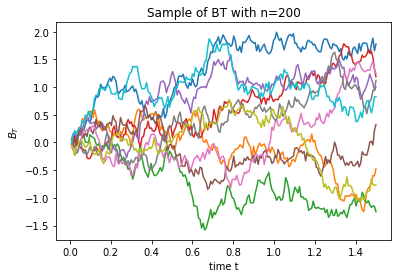

In [13]:
plot_sample(sample_B(rho=0)[:10], ylabel="${B_T}$", title=f"Sample of BT with n={n}")
print("")

In [14]:
def Sigma(X, vars):
    ksi = 0.5
    a0 = 1
    a1 = 1
    return ksi*(a0 + a1*X) / np.sqrt(a0**2 + a1**2*vars)

In [15]:
def sample_S_exp(rho=0.5, eta=1, lam=1, S0=100):
    
    X_sample, cov = sample_XT_Cholesky(lam=lam, eta=eta)
    vars = np.diagonal(cov)

    sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars)))
    

    B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho)))
    sum1 = np.cumsum(0.5*(sigma[:, :-1]**2+sigma[:, 1:]**2)*T/n, axis=1)
    sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
    sample = np.hstack((S0*np.ones(repeat).reshape(-1,1), S0*np.exp(-0.5*sum1+sum2)))
    
    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    # print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
         
    return sample

def sample_S_frac(rho=0.5, H=0.5, c=1, S0=100):
    
    X_sample, cov = sample_XT_frac(H=H, c=c)
    vars = np.diagonal(cov)

    sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars)))
    

    B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho)))
    sum1 = np.cumsum(0.5*(sigma[:, :-1]**2+sigma[:, 1:]**2)*T/n, axis=1)
    sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
    sample = np.hstack((S0*np.ones(repeat).reshape(-1,1), S0*np.exp(-0.5*sum1+sum2)))
    
    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    # print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
         
    return sample

(10000, 201)


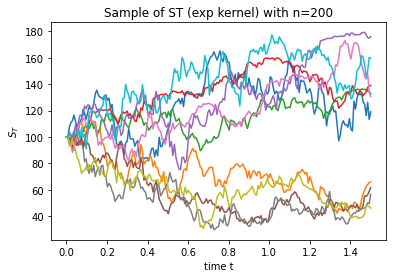

In [16]:
sample = sample_S_exp(rho=-0.8)
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(times, sample[:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (exp kernel) with n={n}")
plt.show()


(10000, 201)


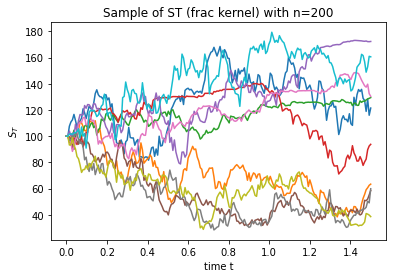

In [17]:
sample = sample_S_frac(rho=-0.8)
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(times, sample[:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (frac kernel) with n={n}")
plt.show()

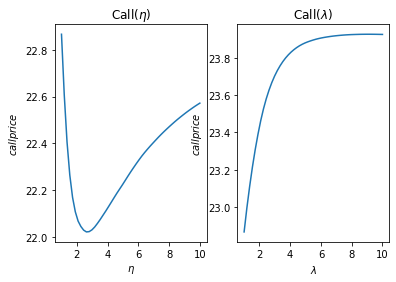

In [18]:
def call_exp(K, rho=0.5, eta=1, lam=1, S0=100):
    return np.mean(np.maximum(sample_S_exp(rho=rho, eta=eta, lam=lam, S0=S0)[:,-1]-K, 0))

fig = plt.figure()
ax = fig.add_subplot(121)

etas = np.linspace(1,10,51)
sample = [call_exp(K=100, eta=eta) for eta in etas]
ax.plot(etas, sample, "-")

ax.set_xlabel("$\eta$")
ax.set_ylabel("$call price$")
ax.set_title("Call($\eta$)")

bx = fig.add_subplot(122)

lambdas = np.linspace(1,10,51)
sample1 = [call_exp(K=100, lam=lam) for lam in lambdas]
bx.plot(lambdas, sample1, "-")

bx.set_xlabel("$\lambda$")
bx.set_ylabel("$call price$")
bx.set_title("Call($\lambda$)")
plt.show()

plt.show()

In [19]:
def call_frac(K, rho=0.5, H=0.5, c=1, S0=100):
    return np.mean(np.maximum(sample_S_frac(rho=rho, H=H, c=c, S0=S0)[:,-1]-K, 0))

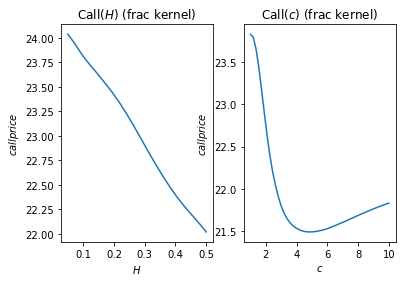

In [20]:
fig = plt.figure()
ax = fig.add_subplot(121)

Hs = np.linspace(0.05,0.5,20)
sample = [call_frac(K=100, H=H) for H in Hs]
ax.plot(Hs, sample, "-")

ax.set_xlabel("$H$")
ax.set_ylabel("$call price$")
ax.set_title("Call($H$) (frac kernel)")

bx = fig.add_subplot(122)

cs = np.linspace(0.1, 5, 51)
sample1 = [call_frac(K=100, c=c) for c in cs]
bx.plot(lambdas, sample1, "-")

bx.set_xlabel("$c$")
bx.set_ylabel("$call price$")
bx.set_title("Call($c$) (frac kernel)")

plt.show()

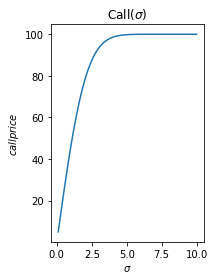

In [21]:
from scipy.stats import norm

# Gaussian distributions, as reference
N_prime = norm.pdf
N = norm.cdf

def black_scholes_call(S, K, T, r, sigma):
    """

    :param S: Asset price
    :param K: Strike price
    :param T: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    """

    # standard black-scholes formula
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * N(d1) - N(d2) * K * np.exp(-r * T)
    return call

black_scholes_call(S=100, K=100, T=T, r=0, sigma=0.5)

fig = plt.figure()
ax = fig.add_subplot(121)

sigmas = np.linspace(0.1,10,100)
sample = [black_scholes_call(S=100, K=100, T=T, r=0, sigma=sigma) for sigma in sigmas]
ax.plot(sigmas, sample, "-")

ax.set_xlabel("$\sigma$")
ax.set_ylabel("$call price$")
ax.set_title("Call($\sigma$)")


plt.show()

In [35]:
def call_frac_bisection(C, S0, K, tol=0.0001, max_iterations=100):
    """

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    """

    # assigning initial volatility estimate for input in Newton_rap procedure
    aH = 0
    bH = 0.5
    H = 0.25
    
    ac = 0
    bc = 4
    c = 2

    for i in range(max_iterations):

        # calculate difference between blackscholes price and market price with
        # iteratively updated volality estimate
        diff = call_frac(K=K, rho=0.5, H=H, c=c, S0=S0) - C

        # break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        # use bisection method to update the estimate
        if diff < 0:
            bH = H
            H = 0.5 * (aH + bH)
        if diff > 0:
            aH = H
            H = 0.5 * (aH + bH)
            
        # calculate difference between blackscholes price and market price with
        # iteratively updated volality estimate
        diff = call_frac(K=K, rho=0.5, H=H, c=c, S0=S0) - C

        # break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        # use bisection method to update the estimate
        if diff < 0:
            bc = c
            c = 0.5 * (ac + bc)
        if diff > 0:
            ac = c
            c = 0.5 * (ac + bc)

    return H, c


H,c = call_frac_bisection(C=call_frac(K=100, H=0.3, rho=0.5, c=1, S0=100), S0=100, K=100, tol=0.001, max_iterations=100)
print(H,c)
print(call_frac(K=100, H=0.3, rho=0.5, c=1, S0=100))
print(call_frac(K=100, H=H, rho=0.5, c=c, S0=100))

0.33984375 0.6875
22.903778052460925
22.903738117031033
